$\textbf{Introduction and Exercise}$

This is a study of automobile demand, as a function of disposable income, US mortage rates and the rate of change of automobile prices.

First lets read in the data from the spread sheets.

We examine the demand for automobiles with US monthly data.  The data set includes two periods of crisis, the Global Financial Crisis and the COVID19 Pandemic. 
In this notebook we compare the forecasting performance of the simple linear model and the neural network model.

Your exercise is to compare the forecasting performance of the two methods when we leave out the period of the global pandemic, ie use the data set only up until 2000.01.

In python, for each array, eliminate the last 20 observations so we end before the start of the Pandemic. 
The way to do this is easy:
n = 20
a1 = a[:-20,:]
You can do that in Cell 11 for x and y.  In other words, forecast only in normal times.

For the full sample we are forecasting with a period high instability taking place at the end of sample and to a lesser extent at the time of the Global Financial Crisis.  I attach a paper by Barbara Rossi about measures to evaluate forecasting performance in such periods.  The Root Mean Squared error may not be the best way.

You can also examine the forecasting performance of the Neural Net methods under alternative assumptions of the activation functions as well as the number of layers and the number of neurons in each layer.

In [1]:

import pandas as pd
import os, sys, re, datetime
from datetime import datetime 
import time
from datetime import datetime, date, time, timedelta

df1 = pd.read_excel('AutoPrices.xls', header=0, names=['observation_date','CUSR0000SETA01'],
                   parse_dates=['observation_date']).iloc[10:]
df1.set_index('observation_date', inplace=True)
df1.index= pd.to_datetime(df1.index)

df2 = pd.read_excel('DAUPSA.xls', header=0, names=['observation_date','DAUPSA'],
                   parse_dates=['observation_date']).iloc[10:]
df2.set_index('observation_date', inplace=True)
df2.index= pd.to_datetime(df2.index)

df3 = pd.read_excel('DisposIncome.xls', header=0, names=['observation_date','DSPIC96'],
                    parse_dates=['observation_date']).iloc[10:]
df3.set_index('observation_date', inplace=True)
df3.index= pd.to_datetime(df3.index)



df4 = pd.read_excel('MORTGAGE15US.xls', header=0, names=['observation_date','MORTGAGE15US'], 
                    parse_dates=['observation_date']).iloc[10:]
df4.set_index('observation_date', inplace=True)
df4.index= pd.to_datetime(df4.index)
df4 = df4.resample('M').last()
df4.index=df4.index+timedelta(days=1)


In [2]:
df1_2 = pd.merge(df1, df2, left_index=True, right_index=True)
df1_2_3 =pd.merge(df1_2, df3, left_index=True, right_index=True)
df =pd.merge(df1_2_3, df4, left_index=True, right_index=True)
df

,CUSR0000SETA01,DAUPSA,DSPIC96,MORTGAGE15US
observation_date,,,,
1993-01-01,130.9,512.9,7237.6,7.68
1993-02-01,131.1,503.8,7271.8,7.37
1993-03-01,131.3,498.1,7249.2,7.02
1993-04-01,131.7,510.2,7286.8,7.01
1993-05-01,132.2,512.8,7276.3,6.91
...,...,...,...,...
2021-05-01,151.693,128.1,15598.1,2.31
2021-06-01,154.68,120.3,15517.7,2.27
2021-07-01,157.34,142.2,15617.6,2.34


In [3]:
df = df.rename({'CUSR0000SETA01':'AutoPrice', 'DAUPSA':'AutoProd','DSPIC96':'DisIncome', 'MORTGAGE15US':'MortRate'}, axis=1)
df

,AutoPrice,AutoProd,DisIncome,MortRate
observation_date,,,,
1993-01-01,130.9,512.9,7237.6,7.68
1993-02-01,131.1,503.8,7271.8,7.37
1993-03-01,131.3,498.1,7249.2,7.02
1993-04-01,131.7,510.2,7286.8,7.01
1993-05-01,132.2,512.8,7276.3,6.91
...,...,...,...,...
2021-05-01,151.693,128.1,15598.1,2.31
2021-06-01,154.68,120.3,15517.7,2.27
2021-07-01,157.34,142.2,15617.6,2.34


In [4]:
df = df.astype(dtype={'AutoPrice':float,'AutoProd':float,'DisIncome':float, 'MortRate':float})

In [5]:
df.head(20)

,AutoPrice,AutoProd,DisIncome,MortRate
observation_date,,,,
1993-01-01,130.9,512.9,7237.6,7.68
1993-02-01,131.1,503.8,7271.8,7.37
1993-03-01,131.3,498.1,7249.2,7.02
1993-04-01,131.7,510.2,7286.8,7.01
1993-05-01,132.2,512.8,7276.3,6.91
1993-06-01,132.3,489.5,7262.9,6.99
1993-07-01,132.9,468.1,7281.2,6.84
1993-08-01,133.4,457.1,7291.8,6.75
1993-09-01,133.6,441.7,7271.9,6.49


- lets start from 94


In [6]:
df_cur = df.iloc[12:] # shift one year later
df_prev = df.iloc[:-12] 
df.shape, df_cur.shape, df_prev.shape

((345, 4), (333, 4), (333, 4))

Now let's pick out the arrays and look at the data, we see the deep drop in Mortgage Rates after 2010

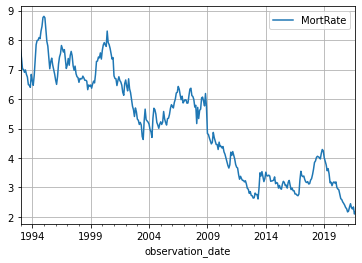

In [7]:
#!pip install --upgrade matplotlib
import matplotlib.pyplot as plt

df.plot(y='MortRate')
plt.grid(True)

## Data Transformation

In [8]:
import numpy as np
df_transformed = pd.DataFrame(columns=df.columns)
for col in df.columns:
    df_transformed[col] =  np.log(df_cur[col].values) - np.log(df_prev[col].values)
    print(df_cur[col].values.shape)
df_transformed.index = df_cur.index

(333,)
(333,)
(333,)
(333,)


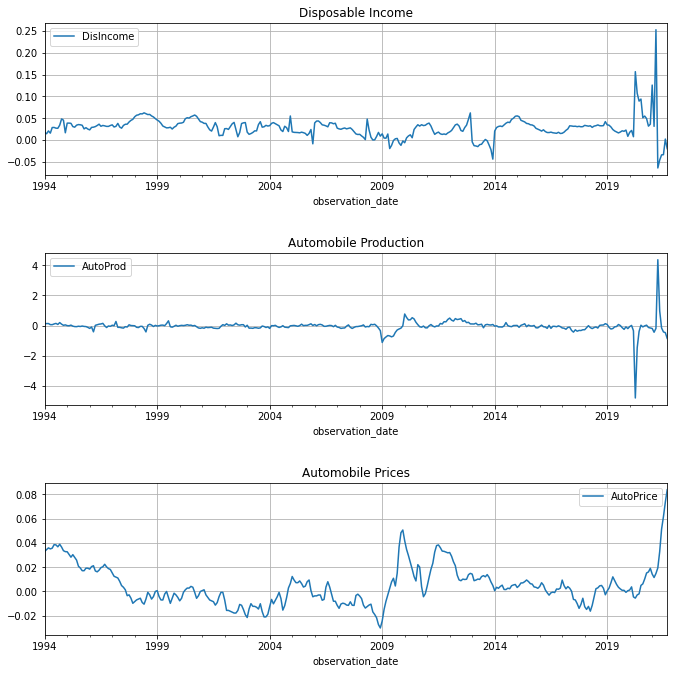

In [9]:
import matplotlib.pyplot as plt
#!pip install tensorflow
#import tensorflow as tf
fig,axes = plt.subplots(nrows=3,figsize=(10,10))
ax = axes[0]
df_transformed.plot(ax=ax,title='Disposable Income', y='DisIncome')
ax.grid(True)
ax = axes[1]
df_transformed.plot(ax=ax,y='AutoProd', title='Automobile Production')
ax.grid(True)
ax = axes[2]
df_transformed.plot(ax=ax,y='AutoPrice', title='Automobile Prices')
ax.grid(True)
fig.tight_layout(pad=3.0)


In [10]:
 df_transformed.iloc[12:]

,AutoPrice,AutoProd,DisIncome,MortRate
observation_date,,,,
1995-01-01,0.032718,-0.001736,0.038708,0.284283
1995-02-01,0.030481,-0.012928,0.038805,0.303020
1995-03-01,0.028253,0.031404,0.038250,0.204141
1995-04-01,0.030327,-0.036327,0.030809,0.086555
1995-05-01,0.028069,-0.065408,0.029413,-0.006390
...,...,...,...,...
2021-05-01,0.032890,0.969188,-0.046038,-0.181600
2021-06-01,0.051273,-0.156641,-0.034182,-0.143394
2021-07-01,0.061663,-0.418044,-0.033639,-0.101507


In [11]:
y = df_transformed.iloc[12:]['AutoProd']
normalized_y=(y-y.min())/(y.max()-y.min()) #[0,1]

x = df_transformed.iloc[:-12]
normalized_x=(x-x.min())/(x.max()-x.min())

In [12]:
ry = len(y)
ry

321

Lets do a split of in and out of sample with ols.  Let 85 percent of the sample be for estimaition and the last for the final test of root mean squared error.  He calculate the Hanan-Quinn information criteria for the insample performance with zero lags.

In [13]:
import statsmodels.api as sm
nn = 85*len(y)//100

xin = x.iloc[:nn]
yin = y.iloc[:nn]

xout = x.iloc[nn:]
yout = y.iloc[nn:]

mod = sm.OLS(yin.values, xin.values)
res = mod.fit()

B  = res.params
print(x.columns),
print(B)

yhat_in = np.dot(xin.values, np.expand_dims(B,axis=1))
ehat = yin.values - np.squeeze(yhat_in)
sse = np.dot(ehat.T, ehat)/nn;
hqif =  -2 * np.log(sse) + 2 *len(B)*np.log(np.log(len(xin)))
hqif

Index(['AutoPrice', 'AutoProd', 'DisIncome', 'MortRate'], dtype='object')
[ 3.74363934 -0.36630907 -1.40972822 -0.170074  ]


20.564703774492784

Now lets try the in sample with  lags from zero to 42 to see which lag structure is better


We have the aif bif and the hqif.  They show us that the best, in terms of lowest value, is for zero lags. 

In [14]:
from statsmodels.tsa.tsatools import lagmat
lags = [0,1,2,3,4,5,6,12,24,36,42];
print('lag, hqif, aif, bif')
for i, lag in enumerate(lags):
    
    x11 = lagmat(xin,maxlag=lag, trim="forward", original='in');
    #print('x11',x11.shape)
    
    y11 = yin.iloc[lag:]
    x21 = x11[lag:]
    Y = y11; X = x21;
              
    mod = sm.OLS(X, Y.values)
    res = mod.fit()
    B  = res.params
    
    yhat_in = np.dot(X, B.reshape(-1,1))
    ehat = Y.values - np.squeeze(yhat_in)
    sse = np.dot(ehat.T, ehat)/nn;
    hqif =  -2 * np.log(sse) + 2 *len(B)*np.log(np.log(len(X)))
    aif = -2 * np.log(sse) + 2 *len(B)*np.log(len(X));
    bif  = -2 * np.log(sse) + 2 *len(B)*len(X);
    print('{}: {:.2f}, {:.2f}, {:.2f}'.format(lag,hqif,aif,bif))
#     end
#     hqif1
#     aif1
#     bif1


lag, hqif, aif, bif
0: 9.97, 17.74, 550.53
1: 9.89, 17.65, 548.45
2: 9.77, 17.52, 546.32
3: 9.66, 17.41, 544.22
4: 9.59, 17.33, 542.14
5: 9.61, 17.34, 540.16
6: 9.69, 17.42, 538.25
12: 9.11, 16.80, 525.68
24: 7.11, 14.72, 499.69
36: 6.05, 13.59, 474.66
42: 5.98, 13.47, 462.59


We do the regression for the insample and do the out of sample by multiplying the Bols to the out of sample xout to get 
the prediction yhat_out.  We calculate the error and the Root mean squared error.  We get the value of 0.8722

In [15]:
  
mod = sm.OLS(yin.values, xin.values)
res = mod.fit()

B  = res.params

yhat_out = np.dot(xout.values, np.expand_dims(B,axis=1))
error_out = yout.values - np.squeeze(yhat_out)
sse = np.mean(error_out**2)
rmsq = sse**.5
rmsq


0.8722451541683682

In [16]:
lag_best = 4
xmatrix = lagmat(x,maxlag=lag_best, trim="forward", original='in')
xmatrix2  = xmatrix[lag:,:]

xmatrix1 = sm.add_constant(xmatrix2)

yadj = y[lag:]
xmatrix1_in = xmatrix1[:nn,:]

yadj_in = yadj[:nn]
xmatrix1_out = xmatrix1[nn:,:]

yadj_out = yadj[nn:]
mod = sm.OLS(yadj_in, xmatrix1_in)
res = mod.fit()
B  = res.params
yhat_out = np.dot(xmatrix1_out, np.expand_dims(B,axis=1))
error_out = yadj_out - np.squeeze(yhat_out)


In [17]:
sse = np.mean((error_out ** 2))
rmse_ols = np.sqrt(sse)
rmse_ols

0.9923816077777549

In [18]:
ny = len(yadj)
WL = 100;
TERM = ny - (WL+1)
yadj_rw = np.array(yadj)
xmatrix1_rw = np.array(xmatrix1)
Yhat_out_rw = np.zeros((ny-WL,1))
Error_out_rw = np.zeros((ny-WL,1))


In [19]:
for i in range(1,TERM):
    WLL = WL+(i-1)
    WLLp = WLL +1
    yy = yadj_rw[i:WLL]
    xx = xmatrix1_rw[i:WLL,:]
    xjunk = xmatrix1_rw[WLLp,:]
    mod = sm.OLS(yy, xx)
    res = mod.fit()
    B  = res.params
    Yhat_out_rw[i] = np.dot(xjunk,B)
    Error_out_rw[i] = y[WLLp] - Yhat_out_rw[i]

    
    

In [20]:
sse =  np.mean((Error_out_rw)**2)
rmsq_ols_rw = np.sqrt(sse)
print(rmsq_ols_rw)

0.5924946668347962


In [21]:
xmatrix2_in = xmatrix2[:nn,:]
xmatrix2_out = xmatrix2[nn:,:]

Now lets see if the simple neural network does better out of sample. We feed in the same in and out of sample x and y variables as well as a simple neural net structure

In [25]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
#X, y = make_regression(n_samples=200, random_state=1)
regr = MLPRegressor(random_state=1, max_iter=100000, hidden_layer_sizes =(24,), alpha=.1, solver='lbfgs', 
                    activation='logistic').fit(xmatrix2_in, yadj_in)

yhat_out_nn = regr.predict(xmatrix2_out)

Score = regr.score(xmatrix2_out, yadj_out)
Score1 = np.sqrt(Score)
Score1




0.6892216064548481

In [26]:

error_nn = yadj_out - yhat_out_nn
sse_nn = np.mean((error_nn **2))
rmsq_nn = np.sqrt(sse_nn)
rmsq_nn

1.21337143910871

We see that the simple neural net does not perform as well. Again we are doing a split in the forecasting.  The better way to evaluate relative performance is with the moving window.

In [28]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
poly_feat = PolynomialFeatures(degree=2)
xmatrix2p = poly_feat.fit_transform(xmatrix2)
xmatrix2p1 =  sm.add_constant(xmatrix2p)
xmatrix2p1_in = xmatrix2p1[:nn,:]
xmatrix2p1_out = xmatrix2p1[nn:,:]
mod = sm.OLS(yadj_in, xmatrix2p1_in)
res = mod.fit()
B  = res.params
yhat_out_poly = np.dot(xmatrix2p1_out, np.expand_dims(B,axis=1))
error_out_poly = yadj_out - np.squeeze(yhat_out_poly)
sse = np.mean((error_out_poly)**2)
rmsq_poly = np.sqrt(sse)
rmsq_poly



97.79451572920877

We see that the polynomial really is very bad, relative to the linear models.  With the lags there is a lot of overfitting going on.  Now lets look at the neurla net with a moving window.

In [31]:
rx,cx = xmatrix2.shape
HOR = rx - WL
Error_out_nn_rw = np.zeros((HOR,1))
yhat_out_nn_rw = np.zeros((HOR,1))
for i in range(1,TERM):
    WLL = WL+(i-1)
    WLLp = WLL +1
    yy = yadj_rw[i:WLL]
    xx = xmatrix2[i:WLL,:]
    xjunk = xmatrix2[WLLp,:]
    regr = MLPRegressor(random_state=1, max_iter=100000, hidden_layer_sizes =(20,10,6,5,4,3,2), alpha=.5, solver='adam', 
                    activation='logistic',warm_start=True).fit(xx, yy)
    xnew = xjunk.reshape(1,cx)
    yhat_out_nn_rw[i,:] = regr.predict(xnew)
    Error_out_nn_rw[i] = yadj_rw[WLLp] - yhat_out_nn_rw[i]

In [32]:
sse = np.mean((Error_out_nn_rw)**2)
rmsq_rw_nn = np.sqrt(sse)
print(rmsq_rw_nn, rmsq_ols_rw)

0.5662798702202052 0.5924946668347962


We see that the neural net outperforms the ols with the moving window forecasting.

In [33]:
weights = regr.coefs_
biases = regr.intercepts_

weights_array = np.concatenate([w.flatten() for w in weights])
biases_array = np.concatenate([b.flatten() for b in biases])

parameters = np.concatenate([weights_array, biases_array])

non_zero_weights_biases = np.count_nonzero(parameters)
print(parameters.shape, non_zero_weights_biases)



(781,) 781


In [34]:
df.index = pd.to_datetime(df.index)
date_index = df.index
ry = yadj_rw.shape
ry
print(date_index.shape, Error_out_nn_rw.shape, HOR, ry)


(345,) (179, 1) 179 (279,)


(179,) (179, 1)


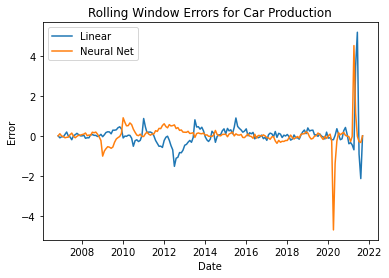

In [35]:
date_index1 = date_index[105:]
rd = date_index1.shape
re = Error_out_nn_rw.shape


start = tuple(rd - re for rd, re in zip(rd, re))
start1 = int(start[0])

date_index2 = date_index1[start1:]
rrd = date_index2.shape
print(rrd, Error_out_nn_rw.shape)
plt.plot(date_index2, Error_out_rw, label='Linear')
plt.plot(date_index2, Error_out_nn_rw, label='Neural Net')
plt.xlabel('Date')
plt.ylabel('Error')
plt.title('Rolling Window Errors for Car Production')
plt.legend()
plt.show()

We picture the graph of the rolling window regressions for the OLS and the Neural Netowrk.
We now use another method, based on the Tensor Flow library.  We have a netowrk of three hidden layers, going from 5,4,3, to the one target variable.

In [54]:
#!pip install tensorflow
import tensorflow as tf

def create_mlp_model(input_dim, l1_reg):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(5, input_dim=input_dim, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l1(l1_reg)))
    model.add(tf.keras.layers.Dense(4, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l1(l1_reg)))
    model.add(tf.keras.layers.Dense(3, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l1(l1_reg)))
    model.add(tf.keras.layers.Dense(1))
    return model

input_dim = xmatrix2_in.shape[1]
mlp = create_mlp_model(input_dim, l1_reg=0.05)
mlp.compile(optimizer='SGD', loss='mean_squared_error')

history = mlp.fit(xmatrix2_in, yadj_in, epochs=1000, batch_size=32, validation_data=(xmatrix2_out, yadj_out))

Epoch 1/1000
9/9 [==============================] - 1s 19ms/step - loss: 3.1163 - val_loss: 4.7314
Epoch 2/1000
9/9 [==============================] - 0s 4ms/step - loss: 2.4815 - val_loss: 4.6120
Epoch 3/1000
9/9 [==============================] - 0s 4ms/step - loss: 2.1787 - val_loss: 4.6001
Epoch 4/1000
9/9 [==============================] - 0s 4ms/step - loss: 2.0217 - val_loss: 4.6195
Epoch 5/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.9328 - val_loss: 4.6400
Epoch 6/1000
9/9 [==============================] - 0s 5ms/step - loss: 1.8765 - val_loss: 4.6554
Epoch 7/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.8344 - val_loss: 4.6603
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 1.8004 - val_loss: 4.6584
Epoch 9/1000
9/9 [==============================] - 0s 6ms/step - loss: 1.7703 - val_loss: 4.6526
Epoch 10/1000
9/9 [==============================] - 0s 5ms/step - loss: 1.7421 - val_loss: 4.6395
Epoch 11/1000
9/9 

Epoch 84/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.4064 - val_loss: 3.3581
Epoch 85/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.3964 - val_loss: 3.3448
Epoch 86/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.3869 - val_loss: 3.3340
Epoch 87/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.3782 - val_loss: 3.3309
Epoch 88/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.3694 - val_loss: 3.3211
Epoch 89/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.3609 - val_loss: 3.3115
Epoch 90/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.3527 - val_loss: 3.3007
Epoch 91/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.3447 - val_loss: 3.2961
Epoch 92/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.3370 - val_loss: 3.2895
Epoch 93/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.3298 - val_loss: 3.2797
Epoch 94/1

9/9 [==============================] - 0s 4ms/step - loss: 0.1460 - val_loss: 3.0975
Epoch 167/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.1452 - val_loss: 3.0958
Epoch 168/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1442 - val_loss: 3.0960
Epoch 169/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1434 - val_loss: 3.0935
Epoch 170/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1424 - val_loss: 3.0943
Epoch 171/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1418 - val_loss: 3.0931
Epoch 172/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1410 - val_loss: 3.0897
Epoch 173/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1405 - val_loss: 3.0871
Epoch 174/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1401 - val_loss: 3.0858
Epoch 175/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1397 - val_loss: 3.0878
Epoch 176/1000


9/9 [==============================] - 0s 4ms/step - loss: 0.1351 - val_loss: 3.0863
Epoch 249/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.1349 - val_loss: 3.0866
Epoch 250/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1349 - val_loss: 3.0870
Epoch 251/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0873
Epoch 252/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0880
Epoch 253/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1350 - val_loss: 3.0885
Epoch 254/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0884
Epoch 255/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0880
Epoch 256/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1349 - val_loss: 3.0850
Epoch 257/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.1349 - val_loss: 3.0838
Epoch 258/1000


9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0912
Epoch 331/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1350 - val_loss: 3.0876
Epoch 332/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0870
Epoch 333/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0880
Epoch 334/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1349 - val_loss: 3.0869
Epoch 335/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.1349 - val_loss: 3.0942
Epoch 336/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1351 - val_loss: 3.0896
Epoch 337/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0892
Epoch 338/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0857
Epoch 339/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0863
Epoch 340/1000


9/9 [==============================] - 0s 3ms/step - loss: 0.1349 - val_loss: 3.0870
Epoch 413/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0867
Epoch 414/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0894
Epoch 415/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0886
Epoch 416/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0889
Epoch 417/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1350 - val_loss: 3.0868
Epoch 418/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.1349 - val_loss: 3.0864
Epoch 419/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1350 - val_loss: 3.0932
Epoch 420/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0913
Epoch 421/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0889
Epoch 422/1000


9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0881
Epoch 495/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1350 - val_loss: 3.0866
Epoch 496/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1349 - val_loss: 3.0851
Epoch 497/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1348 - val_loss: 3.0856
Epoch 498/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0842
Epoch 499/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0845
Epoch 500/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0864
Epoch 501/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0868
Epoch 502/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0852
Epoch 503/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0877
Epoch 504/1000


9/9 [==============================] - 0s 4ms/step - loss: 0.1350 - val_loss: 3.0868
Epoch 577/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0850
Epoch 578/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0858
Epoch 579/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1350 - val_loss: 3.0857
Epoch 580/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0863
Epoch 581/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1350 - val_loss: 3.0877
Epoch 582/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1350 - val_loss: 3.0866
Epoch 583/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0854
Epoch 584/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0855
Epoch 585/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1350 - val_loss: 3.0854
Epoch 586/1000


9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0859
Epoch 659/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0861
Epoch 660/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0853
Epoch 661/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1350 - val_loss: 3.0874
Epoch 662/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.1349 - val_loss: 3.0865
Epoch 663/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1348 - val_loss: 3.0858
Epoch 664/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1350 - val_loss: 3.0852
Epoch 665/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1350 - val_loss: 3.0853
Epoch 666/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0856
Epoch 667/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1350 - val_loss: 3.0893
Epoch 668/1000


9/9 [==============================] - 0s 5ms/step - loss: 0.1350 - val_loss: 3.0866
Epoch 741/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0861
Epoch 742/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0852
Epoch 743/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0885
Epoch 744/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1350 - val_loss: 3.0871
Epoch 745/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0875
Epoch 746/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0851
Epoch 747/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0857
Epoch 748/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0885
Epoch 749/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0875
Epoch 750/1000


9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0880
Epoch 823/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0868
Epoch 824/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0867
Epoch 825/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0878
Epoch 826/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1349 - val_loss: 3.0899
Epoch 827/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.1350 - val_loss: 3.0879
Epoch 828/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0868
Epoch 829/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1350 - val_loss: 3.0857
Epoch 830/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0859
Epoch 831/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0863
Epoch 832/1000


9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0911
Epoch 905/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1350 - val_loss: 3.0891
Epoch 906/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0886
Epoch 907/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1349 - val_loss: 3.0872
Epoch 908/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0865
Epoch 909/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0860
Epoch 910/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0861
Epoch 911/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1351 - val_loss: 3.0847
Epoch 912/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0832
Epoch 913/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1349 - val_loss: 3.0820
Epoch 914/1000


9/9 [==============================] - 0s 5ms/step - loss: 0.1349 - val_loss: 3.0877
Epoch 987/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1350 - val_loss: 3.0874
Epoch 988/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0874
Epoch 989/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1350 - val_loss: 3.0882
Epoch 990/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1350 - val_loss: 3.0862
Epoch 991/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0866
Epoch 992/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0851
Epoch 993/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 3.0854
Epoch 994/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1350 - val_loss: 3.0920
Epoch 995/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1350 - val_loss: 3.0883
Epoch 996/1000


In [55]:
yhat_out= mlp.predict(xmatrix2_out)

yhat_out = yhat_out.ravel()



ERROR = yadj_out - yhat_out


1/1 [==============================] - 0s 63ms/step


In [56]:
sse = np.mean(ERROR**2)
rmsq_nn1 = np.sqrt(sse)
rmsq_nn1

1.756053978499865

We see that this network does not do as well as the eariler more complex one with more neurons.